# Imports

In [32]:
import albumentations as a
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import torch.nn as nn

from albumentations.pytorch import ToTensor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import SGD 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm

from focal_loss import FocalLoss
from mish import Mish

### Versions of libs

In [2]:
np.__version__

'1.17.2'

In [3]:
torch.__version__

'1.3.0'

# Load data

In [4]:
data_folder = './traffic-signs-data/'

with open(os.path.join(data_folder,'train.p'), mode='rb') as f:
    train = pickle.load(f)
with open(os.path.join(data_folder,'valid.p'), mode='rb') as f:
    valid = pickle.load(f)
with open(os.path.join(data_folder,'test.p'), mode='rb') as f:
    test = pickle.load(f)

# Data exploration

Check the stored data

In [5]:
train.keys(), valid.keys(), test.keys()

(dict_keys(['coords', 'labels', 'features', 'sizes']),
 dict_keys(['coords', 'labels', 'features', 'sizes']),
 dict_keys(['sizes', 'coords', 'features', 'labels']))

Assign varaibles

In [6]:
X_train, y_train, coords_train, sizes_train = train['features'], train['labels'], train['coords'], train['sizes']
X_valid, y_valid, coords_valid, sizes_valid = valid['features'], valid['labels'], valid['coords'], valid['sizes']
X_test, y_test, coords_test, sizes_test = test['features'], test['labels'], test['coords'], test['sizes']

Get basic information about the dataset

In [7]:
print("Number of training examples =", X_train.shape[0])
print("Number of validation examples =", X_valid.shape[0])
print("Number of testing examples =", X_test.shape[0])

height, width, channels = X_train.shape[1:]
print(f"Image data shape = {width}x{height}, channels={channels}, dtype={X_train.dtype}")
n_classes = len(set(train['labels']))
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = 32x32, channels=3, dtype=uint8
Number of classes = 43


Check sample images

In [30]:
# TODO find file with class names

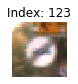

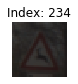

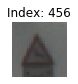

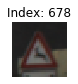

In [8]:
def preview_image(img, text):
    plt.figure(figsize=(1,1))
    plt.title(text)
    plt.axis('off')
    plt.imshow(img)

def preview_image_from_dataset(dataset, index):
    preview_image(dataset[idx], f"Index: {index}")

for idx in [123,234,456,678]:
    preview_image_from_dataset(X_train, idx)
    
# TODO generate more images and keep them in grid

Check histogram of classes

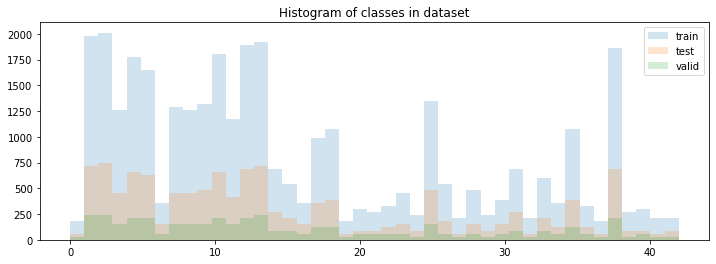

In [9]:
plt.figure(figsize=(12,4))
plt.title("Histogram of classes in dataset")

plt.hist(y_train,bins = n_classes, alpha=0.2, label = 'train')
plt.hist(y_test,bins = n_classes, alpha=0.2, label='test')
plt.hist(y_valid,bins = n_classes, alpha=0.2, label='valid')

plt.legend()
pass

Similarity of distribution of number of items per class in train/test/valid seems to be good

# Preprocessing

Trainig and testing use two separate augmentation pipelines.

Test augmentation uses only normalization to keep all pixel values in range between -1 and 1.  

Training augmentation does the same while adding some rangom transformation to make train dataset more generalized and prevent overfitting to given images.

In [10]:
train_augmentation = a.Compose([
    a.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=20, p=1),
    a.RandomBrightness(0.2,p=1),
    a.RandomContrast(0.2, p=1),
    a.GaussNoise(var_limit=(0,10), p=1),
    a.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)),
    ToTensor()
])

test_augmentation = a.Compose([
    a.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)),
    ToTensor()
])

In [29]:
# TODO sample images from augmentation

In [11]:
class TrafficSignsDataset(Dataset):
    def __init__(self, features, labels, augmentation):
        self.features = features.copy()
        self.labels  = labels.copy()
        self.augmentation = augmentation
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, index, noaug=False):
        img = self.features[index]
        if noaug:
            img = img
        else:
            img = self.augmentation(image=img)['image']
        
        label = int(self.labels[index])
        
        return img, label

In [12]:
train_dataset = TrafficSignsDataset(X_train, y_train, train_augmentation)
test_dataset = TrafficSignsDataset(X_test, y_test, test_augmentation)
valid_dataset = TrafficSignsDataset(X_valid, y_valid, test_augmentation)

Check if datasets work:

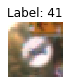

In [13]:
img, label = train_dataset.__getitem__(123, noaug=True)
preview_image(img, f"Label: {label}")

# Model

Used model is simple having (Conv,Pool,Activate, BatchNorm) sequences repeated 4 times.  
After those classification layers (2 Linear separated by Dropout) are used.

There were tests done with state-of-the-art models yt there were inaccurate for that small input as 32x32 where most of them are trained and measured with 224x224 resolution or more. There were two options to choose:
- scale up images
- use simeplier model  
Second option was used to keep training faster.  
Model below weights only about 16MB when trained.  

Model uses activation function from "Mish: A Self Regularized Non-Monotonic Neural Activation Function"  
Link to paper: https://arxiv.org/abs/1908.08681v1  
Implementation for PyTorch aken from https://github.com/lessw2020/mish  

In [15]:
class TSModel(nn.Module):
    def __init__(self, n_classes):
        super(TSModel, self).__init__()
        self.feats = nn.Sequential(
            nn.Conv2d(3, 32, 5, 1, 1),
            nn.MaxPool2d(2, 2),
            Mish(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, 3,  1, 1),
            Mish(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, 3,  1, 1),
            nn.MaxPool2d(2, 2),
            Mish(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            Mish(),
            nn.BatchNorm2d(128)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128,128)
        self.mish = Mish()
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(128, n_classes)

    def forward(self, inputs):
        out = self.feats(inputs)
        out = self.avg_pool(out)
        out = out.view(-1, 128)
        out = self.fc(out)
        out = self.mish(out)
        out = self.dropout(out)
        out = self.classifier(out)

        return out
model=TSModel(n_classes)

Checking if sample outut has proper shape

In [16]:
dummy = torch.zeros((1,3,32,32))
model.eval()
model(dummy).shape

torch.Size([1, 43])

# Training

### Train code

In [17]:
class MetricsAggregator:
    def __init__(self):
        self.epoch_index = -1
        self.loss_history = {}
        self.accuracy_history = {}
    
    def epoch_start(self):
        self.epoch_index += 1
        
    def __add_loss(self, loss):
        if self.epoch_index not in self.loss_history:
            self.loss_history[self.epoch_index] = []
        self.loss_history[self.epoch_index].append(loss)
        
    def __add_acc(self, acc):
        if self.epoch_index not in self.accuracy_history:
            self.accuracy_history[self.epoch_index] = []
        self.accuracy_history[self.epoch_index].append(acc)
        
    def add(self, loss, pred:np.ndarray, gt:np.ndarray):
        self.__add_loss(loss)
        
        pred = np.argmax(pred,axis=1)
        acc = np.sum(pred==gt)/pred.shape[0]
        self.__add_acc(acc)
    
    def get_mean_loss(self, samples=None):
        if samples is None:
            return np.mean(self.loss_history[self.epoch_index])
        return np.mean(self.loss_history[self.epoch_index][-samples:])
    
    def get_mean_acc(self, samples=None):
        if samples is None:
            return np.mean(self.accuracy_history[self.epoch_index])
        return np.mean(self.accuracy_history[self.epoch_index][-samples:])
    
    def get_epochs_losses(self):
        result = []
        for i in range(self.epoch_index+1):
            result.append(np.mean(self.loss_history[i]))
        return result
    
    def get_epochs_acc(self):
        result = []
        for i in range(self.epoch_index+1):
            result.append(np.mean(self.accuracy_history[i]))
        return result

In [18]:
def train(net, loader, aggregator, criterion, device, progress_bar):
    aggregator.epoch_start()
    net.train()
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        aggregator.add(float(loss.item()), outputs.cpu().detach().numpy(), labels.cpu().detach().numpy())
        batch_loss = aggregator.get_mean_loss(1)
        total_loss = aggregator.get_mean_loss()
        batch_acc = aggregator.get_mean_acc(1)
        total_acc = aggregator.get_mean_acc()
        progress_bar.update(1)

In [19]:
def test(net, loader, aggregator, criterion, device):
    net.eval()
    aggregator.epoch_start()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            aggregator.add(float(loss.item()), outputs.cpu().detach().numpy(), labels.cpu().detach().numpy())
            batch_loss = aggregator.get_mean_loss(1)
            total_loss = aggregator.get_mean_loss()
            batch_acc = aggregator.get_mean_acc(1)
            total_acc = aggregator.get_mean_acc()


### Training execution

In [20]:
batch_size = 256
num_workers = 12
train_dataloader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=num_workers)
post_train_dataloader = DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset,batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [21]:
running_train_metrics = MetricsAggregator()
train_metrics = MetricsAggregator()
val_metrics = MetricsAggregator()

In [22]:
best_acc = 0
device = "cuda"
model = model.to(device)

Training uses Focal Loss function described in https://arxiv.org/pdf/1708.02002.pdf  
The implementation was taken from https://github.com/clcarwin/focal_loss_pytorch

In [23]:
epochs = 20
criterion = FocalLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, patience=2,  min_lr=1e-8, factor=0.5)

In [24]:
with tqdm(desc='Training', total=epochs*len(train_dataloader)) as p:
    for epoch in range(epochs):
        train(model, train_dataloader, running_train_metrics, criterion, device, p)
        test(model, train_dataloader, train_metrics, criterion, device)
        test(model, valid_dataloader, val_metrics, criterion, device)
        
        # Save best model
        isbest=''
        if( val_metrics.get_mean_acc() > best_acc):
            best_acc = val_metrics.get_mean_acc()
            isbest = '(saved)'
            torch.save(model.state_dict(), "best.pth")
            
        print(f"[E{epoch+1}] TrainAcc: {train_metrics.get_mean_acc():0.3f} ValidAcc{isbest}: {val_metrics.get_mean_acc():0.3f}")
                
        scheduler.step(val_metrics.get_mean_loss())
        p.update(1)

/home/bmatuszewki/Projects/CarND-Traffic-Sign-Classifier-Project/focal_loss.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


[E1] TrainAcc: 0.295 ValidAcc(saved): 0.260
[E2] TrainAcc: 0.383 ValidAcc(saved): 0.330
[E3] TrainAcc: 0.537 ValidAcc(saved): 0.531
[E4] TrainAcc: 0.589 ValidAcc(saved): 0.575
[E5] TrainAcc: 0.774 ValidAcc(saved): 0.736
[E6] TrainAcc: 0.837 ValidAcc(saved): 0.782
[E7] TrainAcc: 0.900 ValidAcc(saved): 0.879
[E8] TrainAcc: 0.932 ValidAcc(saved): 0.916
[E9] TrainAcc: 0.946 ValidAcc(saved): 0.947
[E10] TrainAcc: 0.958 ValidAcc(saved): 0.948
[E11] TrainAcc: 0.944 ValidAcc: 0.934
[E12] TrainAcc: 0.966 ValidAcc(saved): 0.963
[E13] TrainAcc: 0.959 ValidAcc: 0.950
[E14] TrainAcc: 0.974 ValidAcc(saved): 0.969
[E15] TrainAcc: 0.969 ValidAcc: 0.956
[E16] TrainAcc: 0.982 ValidAcc: 0.955
[E17] TrainAcc: 0.974 ValidAcc: 0.967
[E18] TrainAcc: 0.987 ValidAcc(saved): 0.972
[E19] TrainAcc: 0.992 ValidAcc: 0.965
[E20] TrainAcc: 0.989 ValidAcc: 0.968



### Post train checks

In [25]:
if os.path.isfile('best.pth'):
    print("Loaded model.")
    model.load_state_dict(torch.load('best.pth'))
    
model = model.to('cuda')

final_val_metrics = MetricsAggregator()
final_test_metrics = MetricsAggregator()

test(model, valid_dataloader, final_val_metrics, criterion, device)
test(model, test_dataloader, final_test_metrics, criterion, device)

print(f"Valid loss: {final_val_metrics.get_mean_loss()} Valid acc: {final_val_metrics.get_mean_acc()}")
print(f"Test loss: {final_test_metrics.get_mean_loss()} Test acc: {final_test_metrics.get_mean_acc()}")

Loaded model.
Valid loss: 0.11347928943319453 Valid acc: 0.9715187978927202
Test loss: 0.11618406601250171 Test acc: 0.9656322674418605


# Visualization

### Training/validation loss curves

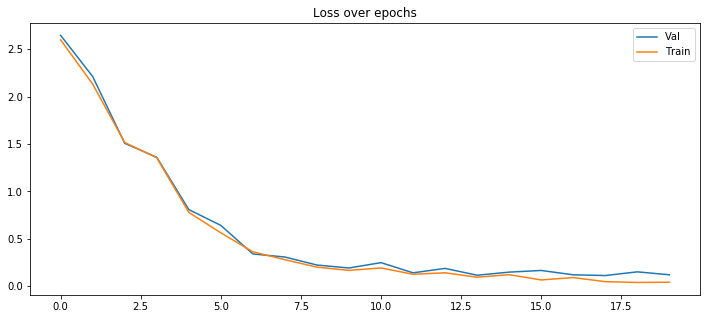

In [26]:
plt.figure(figsize=(12,5))
plt.title("Loss over epochs")
plt.plot(val_metrics.get_epochs_losses(), label='Val')
plt.plot(train_metrics.get_epochs_losses(), label='Train')
plt.legend()

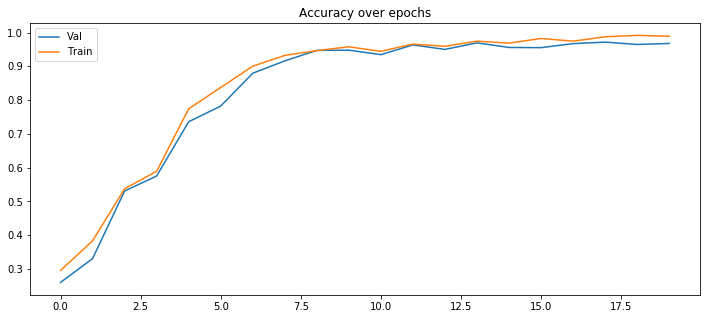

In [27]:
plt.figure(figsize=(12,5))
plt.title("Accuracy over epochs")
plt.plot(val_metrics.get_epochs_acc(), label='Val')
plt.plot(train_metrics.get_epochs_acc(), label='Train')
plt.legend()

In [31]:
# TODO plot confusion matrix

### External sample traffic signs

In [28]:
# TODO get sample images from the net and classify them